# PyTorch Model Deployment

we will be deploying the same model that we trained in the previous notebook i.e. [pizza-steak-sushi classification]. <br>

Criteria to meet: <br>
* The model should work on a mobile device.
* The model should make predictions fast.
* Where is it going to go?
    - On-device?
    - On the cloud?
* How will it be used?
    - Real-time?
    - offline [Batch processing]?
    


# 0. Getting Setup

In [1]:
import os 
import sys
sys.path.append('../2.Going_Modular/') 

In [3]:
from pathlib import Path
import zipfile
import requests
from going_modular import data_setup, engine, utils #type: ignore

import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchinfo import summary

import matplotlib.pyplot as plt

#### HYPERPARAMETERS:

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
NUM_WORKERS = 4

In [11]:
from typing import List

def set_seeds(seed:int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()



def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

# 1. Get the data

In [5]:
# this time we will be using same dataset but the one with more samples 
import requests

data = Path('data')
image_path = data/"pizza_steak_sushi_20_percent"

if image_path.exists():
    print(f"{image_path} directory already exists . . ")
else:
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data/"pizza_steak_sushi_20_percent.zip",'wb') as f:
        print(" Downloading the dataset . . . .")
        response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        f.write(response.content)
        print(" Suceccfully donwnloaded the dataset ")
        
    with zipfile.ZipFile(data/"pizza_steak_sushi_20_percent.zip",'r') as z:
        z.extractall(image_path)
        
os.remove(data/"pizza_steak_sushi_20_percent.zip")
    
    

data\pizza_steak_sushi_20_percent directory already exists . . 


In [13]:
train_dir = image_path/"train"
test_dir =image_path/"test"

# 2. EffNet or ViT?

Different models have different trade-offs. The EfficientNet models are smaller and faster to run than the Vision Transformer models but the Vision Transformer models have been shown to perform well on a variety of tasks. <br>
The selection of the model in this case will depend on the: <br>
* Accuracy
* Speed

## 2.1 Analyzing EffNetB2

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

for param in effnetb2.parameters():
    param.requires_grad = False
    

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

### Creating a function to do all these

In [24]:
def create_effnetb2_model(num_classes : int=3,
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    for param in model.parameters():
        param.requires_grad = False
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features= num_classes)
    ).to(device)
    return model, transforms

In [25]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

### Make dataloader for efnetb2

In [26]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=16)

### Train EffNetB2 

In [27]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9235 | train_acc: 0.5991 | test_loss: 0.6560 | test_acc: 0.9083
Epoch: 2 | train_loss: 0.6057 | train_acc: 0.8470 | test_loss: 0.4967 | test_acc: 0.9313
Epoch: 3 | train_loss: 0.5092 | train_acc: 0.8642 | test_loss: 0.4006 | test_acc: 0.9437
Epoch: 4 | train_loss: 0.3798 | train_acc: 0.8987 | test_loss: 0.3751 | test_acc: 0.9563
Epoch: 5 | train_loss: 0.3630 | train_acc: 0.9030 | test_loss: 0.3207 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.3682 | train_acc: 0.8944 | test_loss: 0.3075 | test_acc: 0.9521
Epoch: 7 | train_loss: 0.3218 | train_acc: 0.9095 | test_loss: 0.2860 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3325 | train_acc: 0.8901 | test_loss: 0.2649 | test_acc: 0.9625
Epoch: 9 | train_loss: 0.3039 | train_acc: 0.9009 | test_loss: 0.2626 | test_acc: 0.9625
Epoch: 10 | train_loss: 0.3162 | train_acc: 0.8772 | test_loss: 0.2484 | test_acc: 0.9688


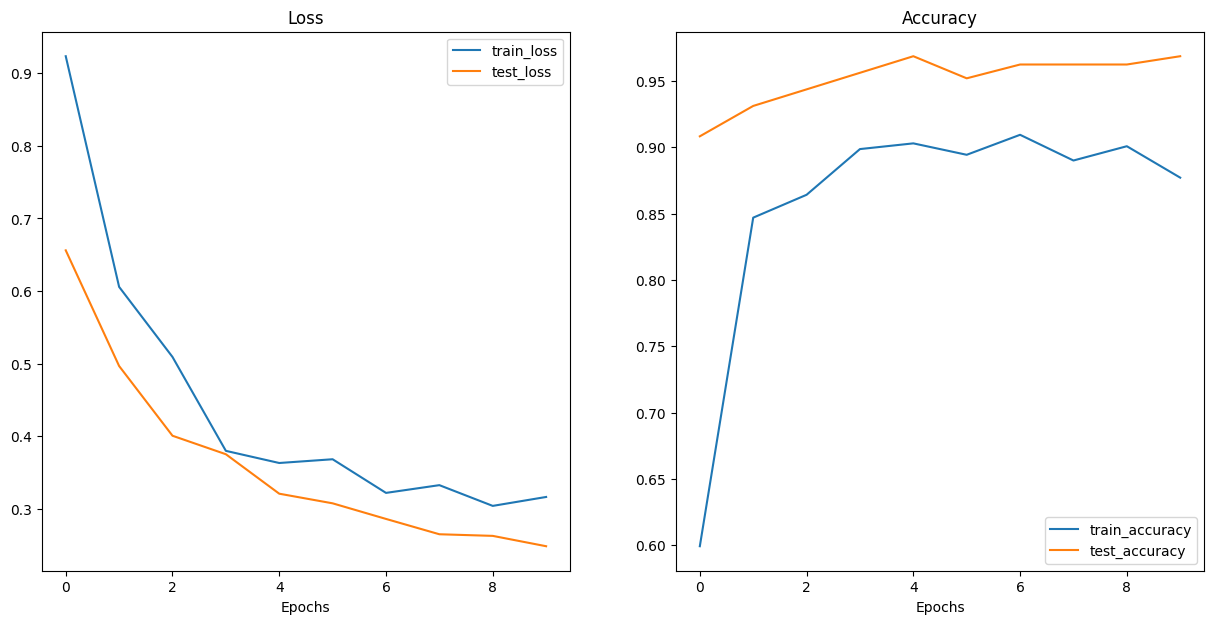

In [28]:
plot_loss_curves(effnetb2_results)

In [31]:
target = Path("Models")
name = "Pretrained_effnet_v2_20_percent.pth"

utils.save_model(model= effnetb2,
           target_dir =  target,
           model_name = name)

[INFO] Saving model to: Models\Pretrained_effnet_v2_20_percent.pth
